![](img/330-banner.png)

# Lecture 12: Feature importances

UBC 2023 Summer

Instructor: Mehrdad Oveisi

## Imports

In [1]:
import os
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("code/.")

import seaborn as sns
from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline

## Learning outcomes 

From this lecture, students are expected to be able to:

- Interpret the coefficients of linear regression for ordinal, one-hot encoded categorical, and scaled numeric features. 
- Explain why interpretability is important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Use `eli5` to get feature importances of non `sklearn` models and interpret its output. 
- Apply SHAP to assess feature importances and interpret model predictions. 
- Explain force plot, summary plot, and dependence plot produced with shapely values.  

## Data 

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in lecture 2. As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [2]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the **target is numeric**, not categorical.

In [3]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [4]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### Let's identify feature types

In [5]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [6]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [7]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

In [8]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['Neighborhood',
 'MoSold',
 'LandSlope',
 'Street',
 'GarageFinish',
 'LandContour',
 'Utilities',
 'MasVnrType',
 'HouseStyle',
 'MSSubClass',
 'Condition1',
 'Condition2',
 'GarageType',
 'LotConfig',
 'CentralAir',
 'MiscFeature',
 'Exterior2nd',
 'Alley',
 'RoofMatl',
 'RoofStyle',
 'PavedDrive',
 'Exterior1st',
 'LotShape',
 'SaleType',
 'Heating',
 'Foundation',
 'SaleCondition',
 'Electrical',
 'MSZoning',
 'BldgType']

In [9]:
categorical_features

['Neighborhood',
 'MoSold',
 'LandSlope',
 'Street',
 'GarageFinish',
 'LandContour',
 'Utilities',
 'MasVnrType',
 'HouseStyle',
 'MSSubClass',
 'Condition1',
 'Condition2',
 'GarageType',
 'LotConfig',
 'CentralAir',
 'MiscFeature',
 'Exterior2nd',
 'Alley',
 'RoofMatl',
 'RoofStyle',
 'PavedDrive',
 'Exterior1st',
 'LotShape',
 'SaleType',
 'Heating',
 'Foundation',
 'SaleCondition',
 'Electrical',
 'MSZoning',
 'BldgType']

In [10]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [11]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [12]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [13]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.372763,-0.222647,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1122,0.154795,-0.222647,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1346,0.154795,-0.222647,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1406,-1.063173,-0.222647,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
X_train_enc.shape

(1314, 263)

In [15]:
lr_pipe = make_pipeline(preprocessor, Ridge())
scores = cross_validate(lr_pipe, X_train, y_train);
pd.DataFrame(scores)

,fit_time,score_time,test_score
0,0.357651,0.120184,0.834450
1,0.270703,0.100805,0.810031
2,0.170387,0.092886,0.831653
3,0.317758,0.110247,0.843537
4,0.197321,0.151495,0.548802


### How does output depend upon the input? 
- How does the prediction change as a function of a particular feature?
- If the model is bad interpretability does not make sense. 

### Simple Feature Correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are **positively correlated**.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are **negatively correlated**.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are **uncorrelated**.

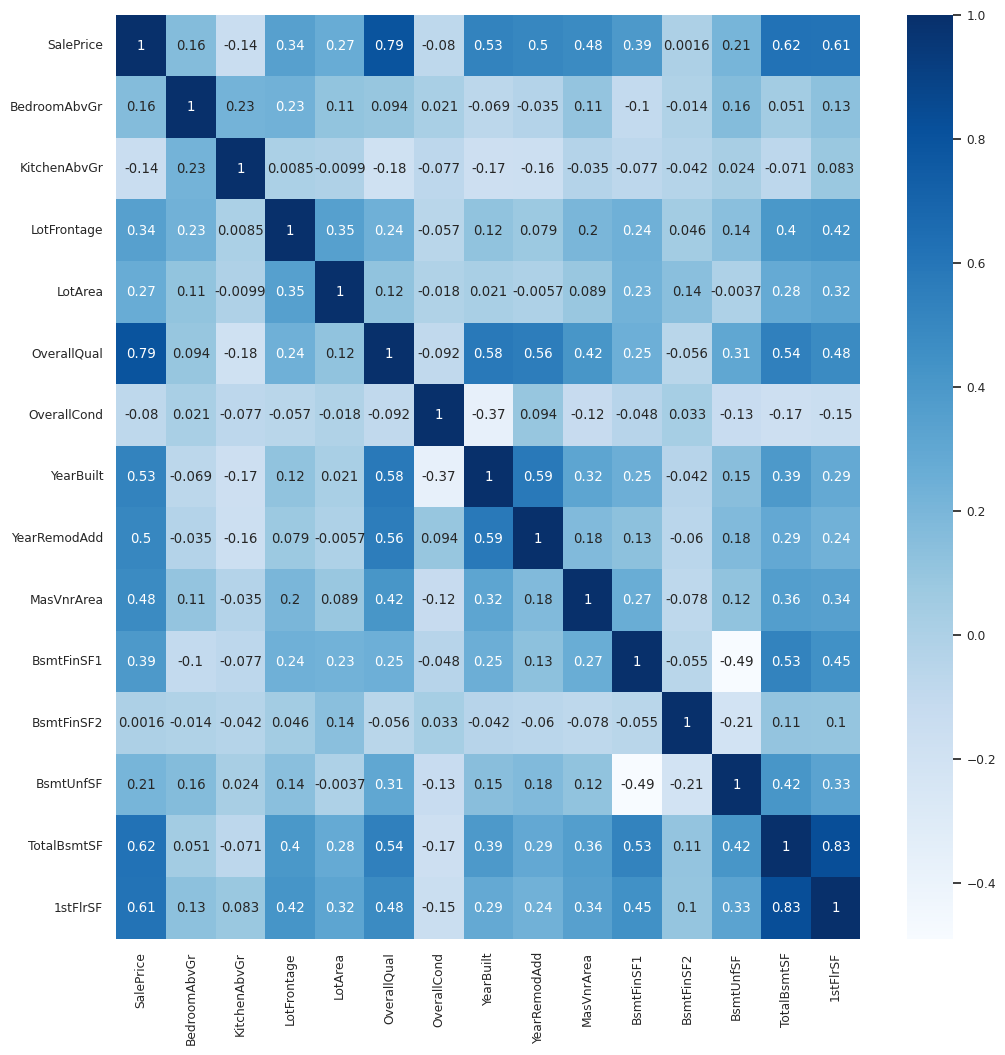

In [16]:
# Get the pairwise correlations between the first 15 columns (including y_train)
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, :15].corr()
plt.figure(figsize=(12, 12))
sns.set(font_scale=.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at **each feature in isolation**.
  - It only looks at **linear associations**:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

<br><br><br><br>

## Feature importance in linear models

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea:<br> predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i

In [17]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

Let's look at the coefficients. 

In [18]:
lr.named_steps.keys()

dict_keys(['columntransformer', 'ridge'])

In [19]:
lr_coefs = pd.DataFrame(data=lr.named_steps['ridge'].coef_,
                        index=new_columns, 
                        columns=["Coefficient"])
lr_coefs.head(20)

,Coefficient
BedroomAbvGr,-3723.741570
KitchenAbvGr,-4580.204576
LotFrontage,-1578.664421
LotArea,5109.356718
OverallQual,12487.561839
OverallCond,4855.535334
YearBuilt,4226.684842
YearRemodAdd,324.664715
MasVnrArea,5251.325210
BsmtFinSF1,3667.172851


### Interpreting coefficients of different types of features. 

### Ordinal features

- The ordinal features are **easiest to interpret**.

In [20]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [21]:
lr_coefs.loc[["ExterQual"]]

,Coefficient
ExterQual,4195.671512


- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.
  - Wow, that's a lot! 
  - Remember this is just what the model has learned. It doesn't tell us how the world works. 

In [22]:
one_example = X_test[:1]

In [23]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [24]:
one_example[["ExterQual"]]

,ExterQual
147,Gd


Let's perturb the example and change `ExterQual` to `Ex`. 

In [25]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = "Ex"  # Change Gd to Ex

In [26]:
one_example_perturbed[["ExterQual"]]

,ExterQual
147,Ex


How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [27]:
print("Prediction on the original example: ", lr.predict(one_example))
print("Prediction on the perturbed example: ", lr.predict(one_example_perturbed))
print(
    "After changing ExterQual from Gd to Ex increased the prediction by: ",
    lr.predict(one_example_perturbed) - lr.predict(one_example),
)

Prediction on the original example:  [224795.63596803]
Prediction on the perturbed example:  [228991.30748049]
After changing ExterQual from Gd to Ex increased the prediction by:  [4195.67151247]


That's exactly the learned coefficient for `ExterQual`! 

In [28]:
lr_coefs.loc[["ExterQual"]]

,Coefficient
ExterQual,4195.671512


So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.

<br><br>

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [29]:
print(categorical_features)

['Neighborhood', 'MoSold', 'LandSlope', 'Street', 'GarageFinish', 'LandContour', 'Utilities', 'MasVnrType', 'HouseStyle', 'MSSubClass', 'Condition1', 'Condition2', 'GarageType', 'LotConfig', 'CentralAir', 'MiscFeature', 'Exterior2nd', 'Alley', 'RoofMatl', 'RoofStyle', 'PavedDrive', 'Exterior1st', 'LotShape', 'SaleType', 'Heating', 'Foundation', 'SaleCondition', 'Electrical', 'MSZoning', 'BldgType']


In [30]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,457.197456
LandSlope_Mod,7420.208381
LandSlope_Sev,-7877.405837


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [31]:
lr_coefs_landslope.loc[["LandSlope_Gtl"]]

,Coefficient
LandSlope_Gtl,457.197456


In [32]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6963.010925
LandSlope_Sev,-8334.603292


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$6963$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8334$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

In [33]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-191129.774314
Condition2_PosN,-105552.840565
Heating_OthW,-27260.681308
MSZoning_C (all),-21990.746193
Exterior1st_ImStucc,-19393.964621
...,...
PoolQC,34217.656047
RoofMatl_CompShg,36525.980874
Neighborhood_NridgHt,37532.643270
Neighborhood_StoneBr,39993.978324


- For example, the above coefficient says that "If the roof is made of clay tile, the predicted price is \\$191K less"?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being **computed**? Yes.
  - Do we believe that this is how the **world works**? No.

In [34]:
# For comparison, we can see all RoofMatl one hot columns:
lr_coefs[lr_coefs.index.str.startswith("RoofMatl")]

,Coefficient
RoofMatl_ClyTile,-191129.774314
RoofMatl_CompShg,36525.980874
RoofMatl_Membran,24537.788381
RoofMatl_Metal,16788.514414
RoofMatl_Roll,8868.963092
RoofMatl_Tar&Grv,7477.664157
RoofMatl_WdShake,13284.152389
RoofMatl_WdShngl,83646.711008


***Note***
> If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one. The interpretation depends on whether we did `drop='first'`, hence the hassle.

> (Optional) When `drop='first'` is set in `OneHotEncoder`, the encoder will drop the first category level of each feature during the one-hot encoding process. This is done to avoid multicollinearity in the encoded features, as including all category levels would result in perfect multicollinearity due to the creation of redundant columns.

<br><br>

### Interpreting coefficients of **numeric features**

Let's look at coefficients of `PoolArea`, `LotFrontage`, `LotArea`. 

In [35]:
lr_coefs.loc[["PoolArea", "LotFrontage", "LotArea"]]

,Coefficient
PoolArea,2822.370476
LotFrontage,-1578.664421
LotArea,5109.356718


Intuition: 

- **Tricky** because numeric features are **scaled**!
- **Increasing** `PoolArea` by ***1 scaled unit*** **increases** the predicted price by $\sim\$2822$.
- **Increasing** `LotArea` by ***1 scaled unit*** **increases** the predicted price by $\sim\$5109$.
- **Increasing** `LotFrontage` by ***1 scaled unit*** **decreases** the predicted price by $\sim\$1578$.

Does that sound reasonable?

- For `PoolArea` and `LotArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?

It's not the case that `LotFrontage` is correlated with some other variable, which might have a larger positive coefficient. 

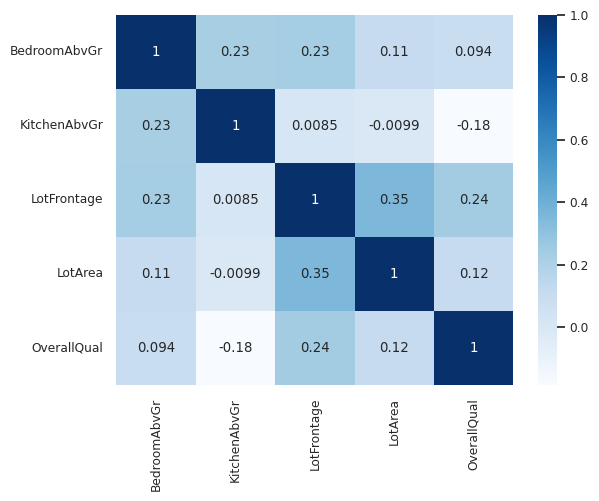

In [36]:
cor = X_train_enc[numeric_features[:5]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

BTW, let's make sure the predictions behave as expected:

### Example showing how to interpret coefficients of scaled features

- What's **one scaled unit** for `LotArea`? 
- The scaler **subtracted** the mean and **divided** by the standard deviation.
- The **division** actually **changed the scale**! 
- For the **unit conversion**, we don't care about the subtraction, but only the scaling (by division).

In [37]:
scaler = preprocessor.named_transformers_["pipeline-1"]["standardscaler"]

In [38]:
scaler.scale_

array([8.21039683e-01, 2.18760172e-01, 2.09591390e+01, 8.99447103e+03,
       1.39208177e+00, 1.11242416e+00, 3.01866337e+01, 2.06318985e+01,
       1.77914527e+02, 4.59101890e+02, 1.63890010e+02, 4.42869860e+02,
       4.42817167e+02, 3.92172897e+02, 4.35820743e+02, 4.69800920e+01,
       5.29468070e+02, 5.18276015e-01, 2.33809970e-01, 5.49298599e-01,
       5.02279069e-01, 1.62604030e+00, 6.34398801e-01, 2.40531598e+01,
       7.40269201e-01, 2.10560601e+02, 1.25388753e+02, 6.57325181e+01,
       6.07432962e+01, 3.03088902e+01, 5.38336322e+01, 4.23249944e+01,
       5.22084645e+02, 1.33231649e+00])

In [39]:
lr_scales = pd.DataFrame(
    data=scaler.scale_, index=numeric_features, columns=["Scale"]
)
lr_scales.head()

,Scale
BedroomAbvGr,0.821040
KitchenAbvGr,0.218760
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082


- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [40]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- The coefficient tells us that if we increase the **scaled** `LotArea` by one unit the price would go up by $\approx\$5109$. 
- One scaled unit represents $\sim 8994$ sq feet (`lr_scales.loc["LotArea", "Scale"]`)

- So if I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [41]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


In [42]:
lr_scales.loc[["LotArea"]]

,Scale
LotArea,8994.471032


In [43]:
5109.356718094072 / 8994.471032

0.5680552752814816

That is, if we increase original `LotArea` by one square foot then the predicted price would go up by $0.57

Let's examine whether this works as expected. In other words 

In [44]:
one_example = X_test[:1]

In [45]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's **perturb** the example and add 1 to the `LotArea`. 

In [46]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1  # add 1 to the LotArea

In [47]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [48]:
lr.predict(one_example)

array([224795.63596803])

Prediction on the perturbed example. 

In [49]:
lr.predict(one_example_perturbed)

array([224796.2040233])

- What's the difference between prediction? 
- Does the difference make sense given the coefficient of the feature? 

In [50]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.56805528])

In [51]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- Why did the prediction only go up by \\$0.57 instead of \\$5109? 
- This is an issue of **units**.
    - `LotArea` is in sqft, but the coefficient is **not** $\$5109/\text{sqft}$ **because we scaled the features**. 

- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- **Correlation** among features might make coefficients completely **uninterpretable**.
- Fairly **straightforward** to interpret coefficients of **ordinal** features.
- In **categorical** features, it's often helpful to consider **one category as a reference** point and think about relative importance.
- For **numeric** features, relative importance is meaningful **after scaling**.
    - You have to be careful about the scale of the feature when interpreting the coefficients.
- Remember that explaining the model $\neq$ explaining the data.
    - the **coefficients** tell us only about the **model** and they might **not** accurately reflect the **data**.

<br><br><br><br>

## Transparency and explainability of ML models

### Discussion
- If you have a machine learning model which gives you 98% cross-validation accuracy and 97% test accuracy on a reasonable sized train and test data on the task of your interest,
  - is it OK to just trust the model and ignore why it made a certain prediction? 
- Discuss scenarios where this might be problematic. 

![](img/shap_example.png)

<!-- <img src="img/shap_example.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Why do we care about transparency and interpretability?

- Transparency of ML model predictions is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 


### What is model interpretability? 

- In this lecture, our definition of model interpretability will be looking at **feature importances**.
- There is more to interpretability than feature importances, but it's a good start!
- Resource: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

<br><br>

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from last lecture. 

In [52]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df = train_df.replace("?", np.NaN)
test_df = test_df.replace("?", np.NaN)
train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [53]:
train_df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,26048.000000,2.604800e+04,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.526912,1.898287e+05,10.088337,1106.465602,88.550561,40.518965
std,13.587602,1.050314e+05,2.580718,7518.611442,406.801027,12.332662
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.785060e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.374528e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


In [54]:
numeric_features = ["capital.gain", "age", "capital.loss", "hours.per.week"]
categorical_features = [
    "marital.status",
    "native.country",
    "relationship",
    "occupation",
    "workclass",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "race", "education.num"]
target_column = "income"

In [55]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [56]:
assert set(education_levels) == set(train_df["education"].unique())

In [57]:
numeric_transformer = StandardScaler()
ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [58]:
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

In [59]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['capital.gain', 'age', 'capital.loss',
                                  'hours.per.week']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate']],
                                                dtype=<class...
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['sex']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['marital.status', 'native.country',
                                  'relationship', 'occupation', 'workclass']),
                                ('drop', 'drop',
                                 ['fnlwgt', 'race', 'education.num'])])

In [60]:
ohe_feats = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
).tolist()

In [61]:
feature_names = numeric_features + ordinal_features + binary_features + ohe_feats

In [62]:
pd.DataFrame(columns=feature_names)

,capital.gain,age,capital.loss,hours.per.week,education,sex,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,...,occupation_missing,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_missing


<br><br>

### Do we have class imbalance? 

- There is class imbalance. But without any context, **both classes seem equally important**. 
- Let's use accuracy as our metric. 

In [63]:
train_df["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [64]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [65]:
results = {}

In [66]:
scoring_metric = "accuracy"

In [67]:
from lightgbm.sklearn import LGBMClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "LightGBM": pipe_lgbm,
}

In [68]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [69]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [70]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.049 (+/- 0.021),0.038 (+/- 0.019),0.629 (+/- 0.007),0.632 (+/- 0.001)
logistic regression,16.696 (+/- 3.800),0.219 (+/- 0.042),0.849 (+/- 0.005),0.850 (+/- 0.001)
random forest,3.781 (+/- 0.864),0.266 (+/- 0.026),0.848 (+/- 0.006),0.979 (+/- 0.000)
LightGBM,0.432 (+/- 0.039),0.085 (+/- 0.012),0.872 (+/- 0.004),0.888 (+/- 0.000)


- Logistic regression is giving reasonable scores but not the best ones. 
- LightGBM is giving us the best CV scores. 

- Often simple models (e.g., linear models) are interpretable but not very accurate.
- Complex models (e.g., LightGBM) are more accurate but less interpretable. 

![](img/shap_motivation.png)

<!-- <img src="img/shap_motivation.png" width="600" height="600"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

### Feature importances in linear models

- **Simpler** models are often **more interpretable** but **less accurate**. 

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [71]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train);

In [72]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:10]

['capital.gain',
 'age',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'marital.status_Divorced',
 'marital.status_Married-AF-spouse',
 'marital.status_Married-civ-spouse',
 'marital.status_Married-spouse-absent']

In [73]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)

In [74]:
coef_df[:10]

,coefficient,magnitude
capital.gain,2.356160,2.356160
marital.status_Married-AF-spouse,1.762059,1.762059
occupation_Priv-house-serv,-1.423881,1.423881
marital.status_Married-civ-spouse,1.350736,1.350736
relationship_Wife,1.294509,1.294509
occupation_Prof-specialty,1.079709,1.079709
native.country_Columbia,-1.078866,1.078866
occupation_Exec-managerial,1.057371,1.057371
native.country_Dominican-Republic,-1.009615,1.009615
relationship_Own-child,-0.981890,0.981890


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

<br><br>

## Model interpretability beyond linear models

We will be looking at three ways for model interpretability. 

- `sklearn` `feature_importances_`    
- [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial) (stands for "explain like I'm 5") 
- [SHAP](https://github.com/slundberg/shap)
    

### Feature importances activity

We have been talking about feature importances given by linear models. How about other models we have seen so far? What might be reasonable ways to calculate feature importances of other models we have seen so far?

- Decision trees
- Other tree-based models such as random forests or LightGBM
- Linear SVMs
- KNNs, RBF SVMs

### `sklearn` `feature_importances_`

- Many `sklearn` models have `feature_importances_` attribute.
- For **tree-based models**, it's calculated based on **impurity** (gini index or information gain).
- `RandomForestClassifier` also has the `feature_importances_` attribute.

#### Decision tree feature importances

In [75]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3))
pipe_dt.fit(X_train, y_train);

In [76]:
data = {
    "Importance": pipe_dt.named_steps["decisiontreeclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
).head(10)

,Importance
marital.status_Married-civ-spouse,0.543351
capital.gain,0.294855
education,0.160727
age,0.001068
native.country_missing,0.000000
occupation_Armed-Forces,0.000000
occupation_Adm-clerical,0.000000
relationship_Wife,0.000000
relationship_Unmarried,0.000000
relationship_Own-child,0.000000


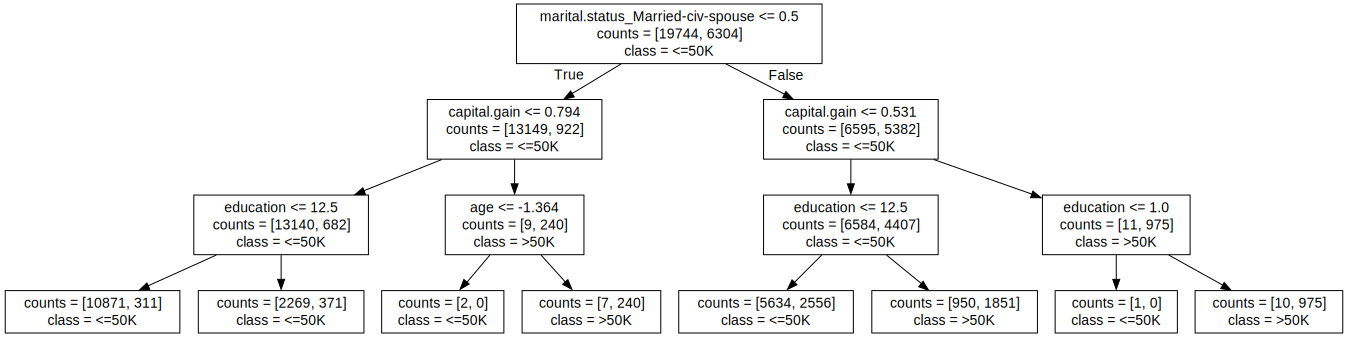

In [77]:
display_tree(feature_names, pipe_dt.named_steps["decisiontreeclassifier"], counts=True)

#### Random forest feature importances

Let's create and fit a pipeline with preprocessor and random forest.

In [78]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train);

Which features are driving the predictions the most? 

In [79]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
rf_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)

In [80]:
rf_imp_df.head(10)

,Importance
age,0.231760
education,0.117826
hours.per.week,0.115728
capital.gain,0.108464
marital.status_Married-civ-spouse,0.075335
relationship_Husband,0.050766
capital.loss,0.037180
marital.status_Never-married,0.028449
occupation_Exec-managerial,0.022496
occupation_Prof-specialty,0.020883


In [81]:
np.sum(pipe_rf.named_steps["randomforestclassifier"].feature_importances_)

1.0

### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about **importance**, but ***not*** an "**up** or **down**".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

<br><br>

Do these importances match with importances identified by logistic regression? 

In [82]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['capital.gain', 'age',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              '1st-4th',
                                                                              '5th-6th',
                                                                              '7th-8th',
                                                                              '9th',
                                                                              '10th',
                                                                              '11th',
                                                                              '12th',
                                                                              'HS-grad',
                                                                              'Prof-school',
                                                                              'Assoc-voc',
                                                                              'Assoc-acdm',
                                                                              'Some-college',
                                                                              'Bachelors'...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['marital.status',
                                                   'native.country',
                                                   'relationship', 'occupation',
                                                   'workclass']),
                                                 ('drop', 'drop',
                                                  ['fnlwgt', 'race',
                                                   'education.num'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=2))])

In [83]:
data = {
    "random forest importances": pipe_rf.named_steps[
        "randomforestclassifier"
    ].feature_importances_,
    "logistic regression importances": pipe_lr.named_steps["logisticregression"]
    .coef_[0]
    .tolist(),
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)

In [84]:
imps.sort_values(by="random forest importances", ascending=False)[:10]

,random forest importances,logistic regression importances
age,0.231760,0.353594
education,0.117826,0.183928
hours.per.week,0.115728,0.367758
capital.gain,0.108464,2.356160
marital.status_Married-civ-spouse,0.075335,1.350736
relationship_Husband,0.050766,0.000838
capital.loss,0.037180,0.280577
marital.status_Never-married,0.028449,-0.925913
occupation_Exec-managerial,0.022496,1.057371
occupation_Prof-specialty,0.020883,1.079709


Let's compare their top ten important feature lists:

In [85]:
col_rf = "random forest importances"
col_lr = "logistic regression importances"

ranking = pd.DataFrame({
    col_rf: imps[col_rf].sort_values(ascending=False).index, 
    col_lr: imps[col_lr].sort_values(ascending=False, key=np.abs).index
}).rename_axis('ranking')

ranking.head(10)

,random forest importances,logistic regression importances
ranking,,
0,age,capital.gain
1,education,marital.status_Married-AF-spouse
2,hours.per.week,occupation_Priv-house-serv
3,capital.gain,marital.status_Married-civ-spouse
4,marital.status_Married-civ-spouse,relationship_Wife
5,relationship_Husband,occupation_Prof-specialty
6,capital.loss,native.country_Columbia
7,marital.status_Never-married,occupation_Exec-managerial
8,occupation_Exec-managerial,native.country_Dominican-Republic


- In their top 10 lists, both models agree on:
  - `capital.gain` 
  - `marital.status_Married-civ-spouse`
  - `occupation_Exec-managerial`
 
- The actual numbers for random forests and logistic regression are not really comparable.

### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

You'll have to install it

`conda install -n cpsc330 -c conda-forge eli5`

Let's look at feature importances for `LGBMClassifier`. 

In [86]:
import eli5

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train)
eli5_lgbm = eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)
eli5_lgbm

Weight,Feature
0.3613,marital.status_Married-civ-spouse
0.1941,capital.gain
0.1411,education
0.0890,age
0.0659,capital.loss
0.0440,hours.per.week
0.0131,occupation_Exec-managerial
0.0115,occupation_Prof-specialty
0.0072,occupation_Other-service
0.0063,sex


You can also look at feature importances for `RandomForestClassifier`. 

In [87]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_rf.fit(X_train, y_train)

eli5_rf = eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)
eli5_rf

Weight,Feature
0.2353 ± 0.0451,age
0.1191 ± 0.0332,education
0.1157 ± 0.0218,hours.per.week
0.1093 ± 0.0510,capital.gain
0.0728 ± 0.1350,marital.status_Married-civ-spouse
0.0471 ± 0.1144,relationship_Husband
0.0395 ± 0.0176,capital.loss
0.0251 ± 0.0711,marital.status_Never-married
0.0214 ± 0.0202,occupation_Prof-specialty
0.0212 ± 0.0209,occupation_Exec-managerial


Let's compare them with weights what we got with `sklearn` `feature_importances_`

In [88]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
sk_feat_imp_rf = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)
sk_feat_imp_rf.head(10)

,Importance
age,0.235295
education,0.119108
hours.per.week,0.115700
capital.gain,0.109320
marital.status_Married-civ-spouse,0.072808
relationship_Husband,0.047109
capital.loss,0.039513
marital.status_Never-married,0.025080
occupation_Prof-specialty,0.021440
occupation_Exec-managerial,0.021167


Let's see all feature importance rankings side by side

In [89]:
def eli5_features(explain_weights):
    return [f.feature for f in explain_weights.feature_importances.importances]

eli5_rows = len(eli5_features(eli5_lgbm))

pd.DataFrame({
    "LGBM eli5": eli5_features(eli5_lgbm),
    "RandomForest eli5": eli5_features(eli5_rf),
    "RandomForest sklearn": sk_feat_imp_rf.head(eli5_rows).index
}).rename_axis('ranking')

,LGBM eli5,RandomForest eli5,RandomForest sklearn
ranking,,,
0,marital.status_Married-civ-spouse,age,age
1,capital.gain,education,education
2,education,hours.per.week,hours.per.week
3,age,capital.gain,capital.gain
4,capital.loss,marital.status_Married-civ-spouse,marital.status_Married-civ-spouse
5,hours.per.week,relationship_Husband,relationship_Husband
6,occupation_Exec-managerial,capital.loss,capital.loss
7,occupation_Prof-specialty,marital.status_Never-married,marital.status_Never-married
8,occupation_Other-service,occupation_Prof-specialty,occupation_Prof-specialty


- These values tell us **globally** about which features are important
- But what if you want to explain a **_specific_ prediction**?
- Some fancier tools can help us do this

<br><br><br><br>

### SHAP  (SHapley Additive exPlanations)
- Based on the idea of shapely values. A shapely value is created for each example and each feature. 
- Can explain the prediction of an example by computing the contribution of each feature to the prediction. 
- Great visualizations 
- Support for different kinds of models; fast variants for tree-based models
- Original paper: [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)

#### Our focus
- How to use it on our dataset?
- How to generate and interpret plots created by SHAP? 
- We are not going to discuss how SHAP works. 


<img src="img/shap_explanation2.png" width="1000" height="1000">

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


- Start at a base rate (e.g., how often people get their loans rejected).
- Add one feature at a time and see how it impacts the decision. 


- Let's try it out on tree-based models. 
- Install `shap` in the course conda environment. 


`conda install -n cpsc330 -c conda-forge shap`

Let's create train and test dataframes with our transformed features. 

In [90]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,capital.gain,age,capital.loss,hours.per.week,education,sex,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,...,occupation_missing,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_missing
5514,-0.147166,-0.921955,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19777,-0.147166,-1.069150,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10781,-0.147166,-0.185975,-0.21768,-0.042081,13.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32240,-0.147166,-1.216346,-0.21768,-1.663822,12.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9876,-0.147166,-0.553965,-0.21768,-0.042081,13.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.shape

(6513, 85)

Let's get SHAP values for train and test data. 

In [92]:
import warnings

# Reactivate default warning settings after disabling them

# As a best practice, try not to suppress warnings without a good reason and
# be sure to reactivate them when suppressing them is not needed anymore.

# To ignore warnings:
# warnings.simplefilter(action="ignore", category=UserWarning)

# To reactivate warnings:
# warnings.simplefilter(action="default", category=UserWarning)

In [93]:
from numba import NumbaDeprecationWarning

warnings.simplefilter(action="ignore", category=NumbaDeprecationWarning)  # ignore warnings
warnings.simplefilter(action="ignore", category=UserWarning)  # ignore warnings

In [94]:
import shap

lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [95]:
warnings.simplefilter(action="default", category=NumbaDeprecationWarning)  # reactivate warnings
warnings.simplefilter(action="default", category=UserWarning)  # reactivate warnings

In [96]:
train_lgbm_shap_values

[array([[ 2.82025568e-01,  4.08151507e-01,  4.70162085e-02, ...,
          8.27503480e-03,  0.00000000e+00,  0.00000000e+00],
        [ 2.77536150e-01,  5.46019608e-01,  4.69698010e-02, ...,
          1.01879416e-02,  0.00000000e+00,  0.00000000e+00],
        [ 2.50475372e-01, -4.39095422e-01,  6.51137414e-02, ...,
         -4.80562283e-03,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.89706451e-01, -1.05137470e+00, -2.74798624e+00, ...,
         -2.26327601e-03,  0.00000000e+00,  0.00000000e+00],
        [ 3.01432486e-01, -6.32247597e-01,  8.99744241e-02, ...,
         -4.46023825e-03,  0.00000000e+00,  0.00000000e+00],
        [ 2.32397724e-01,  1.15559528e+00,  5.55862988e-02, ...,
          8.13910413e-03,  0.00000000e+00,  0.00000000e+00]]),
 array([[-2.82025568e-01, -4.08151507e-01, -4.70162085e-02, ...,
         -8.27503480e-03,  0.00000000e+00,  0.00000000e+00],
        [-2.77536150e-01, -5.46019608e-01, -4.69698010e-02, ...,
         -1.01879416e-02,  0.00000000e

- For each example, **each feature**, and **each class** we have **a SHAP value**.
- SHAP values tell us how to fairly distribute the prediction among features. 
- For classification it's a bit confusing. It gives SHAP matrix for both classes.
- Let's stick to **shap values for class 1, i.e., income > 50K**.

In [97]:
train_lgbm_shap_values[1].shape

(26048, 85)

In [98]:
warnings.simplefilter(action="ignore", category=UserWarning)  # ignore warnings

test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

warnings.simplefilter(action="default", category=UserWarning)  # reactivate warnings

In [99]:
test_lgbm_shap_values[1].shape

(6513, 85)

- You can think of this as **global feature importance**
- But we'll see next that it gives you much more

<br><br><br><br>

## SHAP plots

### Force plots

- Most useful! 
- Let's try to explain predictions on a couple of examples from the test data. 
- I'm sampling some examples where target is <=50K and some examples where target is >50K. 

In [100]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
6508    <=50K
6509    <=50K
6510     >50K
6511    <=50K
6512     >50K
Name: income, Length: 6513, dtype: object

In [101]:
l50k_ind = y_test_reset[y_test_reset == "<=50K"].index.tolist()
g50k_ind = y_test_reset[y_test_reset == ">50K"].index.tolist()

ex_l50k_index = l50k_ind[10]
ex_g50k_index = g50k_ind[10]

### Example with prediction <=50K

In [102]:
pipe_lgbm.named_steps["lgbmclassifier"].classes_

array(['<=50K', '>50K'], dtype=object)

In [103]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_l50k_index]

array([0.99240562, 0.00759438])

In [104]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_l50k_index
]  # raw score of the model

-4.872722908439952

In [105]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)

array([-1.76270194, -7.61912405, -0.45555535, ...,  1.13521135,
       -6.62873917, -0.84062193])

In [106]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_train_enc, raw_score=True).mean()

-2.336411423367732

In [107]:
lgbm_explainer.expected_value[1]  # on average this is the raw score for class 1

-2.3364114233677307

In [108]:
lgbm_explainer.expected_value[0]

2.3364114233677307

In [109]:
X_test_enc = round(X_test_enc, 3)  # for better visualization

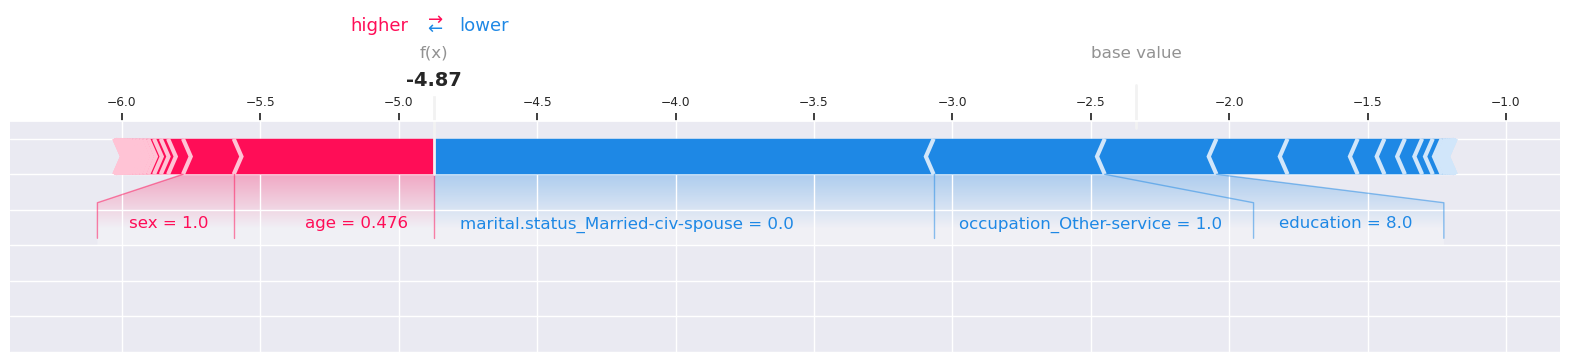

In [110]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_l50k_index, :],
    X_test_enc.iloc[ex_l50k_index, :],
    matplotlib=True,
)

- The raw model score is much smaller than the base value, which is reflected in the prediction of <= 50k class. 
- sex = 1.0, scaled age = 0.48 are pushing the prediction towards higher score. 
- education = 8.0, occupation_Other-service = 1.0 and marital.status_Married-civ-spouse = 0.0 are pushing
the prediction towards lower score. 

In [111]:
pd.DataFrame(
    test_lgbm_shap_values[1][ex_l50k_index, :],
    index=feature_names,
    columns=["SHAP values"],
).sort_values('SHAP values', ascending=False)

,SHAP values
age,0.723502
sex,0.183267
marital.status_Never-married,0.053894
occupation_Machine-op-inspct,0.026332
relationship_Own-child,0.024354
...,...
capital.gain,-0.253426
capital.loss,-0.256666
education,-0.403715
occupation_Other-service,-0.618201


### Example with prediction >50K

In [112]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_g50k_index]

array([0.35997929, 0.64002071])

In [113]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_g50k_index
]  # raw model score

0.5754540510801829

In [114]:
pd.DataFrame(
    test_lgbm_shap_values[1][ex_g50k_index, :],
    index=feature_names,
    columns=["SHAP values"],
)

,SHAP values
capital.gain,-0.295954
age,0.808705
capital.loss,-0.088905
hours.per.week,-0.688912
education,0.890873
...,...
workclass_Self-emp-inc,-0.007650
workclass_Self-emp-not-inc,-0.000750
workclass_State-gov,0.006082
workclass_Without-pay,0.000000


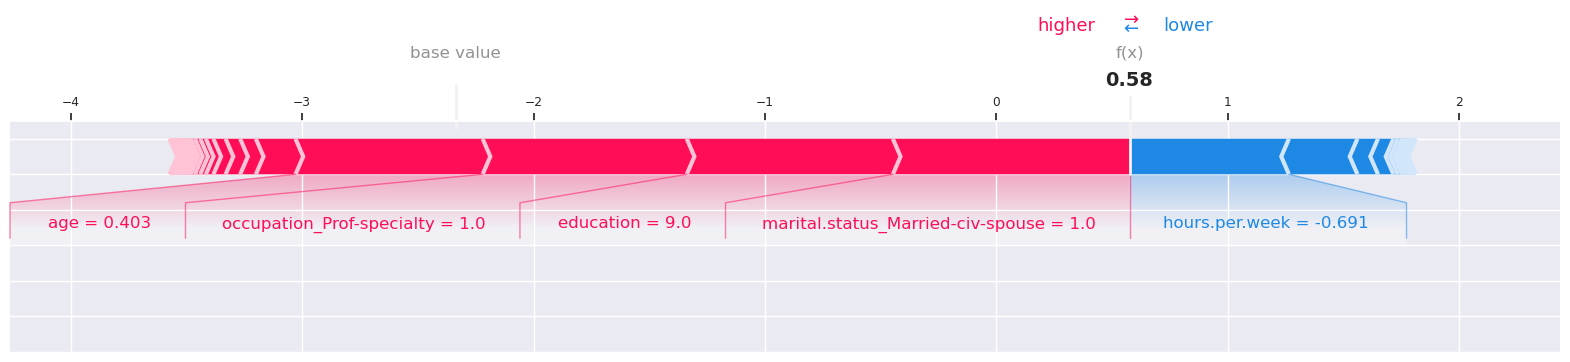

In [115]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_g50k_index, :],
    X_test_enc.iloc[ex_g50k_index, :],
    matplotlib=True,
)

Observations: 

- Everything is with respect to class 1 here. 
- The base value for class 1 is -2.316. (You can think of this as the raw score on average.) 
- We see the forces that drive the prediction. 
- That is, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [116]:
test_lgbm_shap_values[1][ex_g50k_index, :].sum() + lgbm_explainer.expected_value[1]

0.5754540510801851

### Global feature importance using SHAP

Let's look at the average SHAP values associated with each feature. 

In [117]:
values = np.abs(train_lgbm_shap_values[1]).mean(
    0
)  # mean of shapely values in each column
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
marital.status_Married-civ-spouse,1.074859
age,0.805466
capital.gain,0.565589
education,0.417642
hours.per.week,0.324636
sex,0.185686
capital.loss,0.148519
marital.status_Never-married,0.139913
relationship_Own-child,0.108002
occupation_Prof-specialty,0.106276


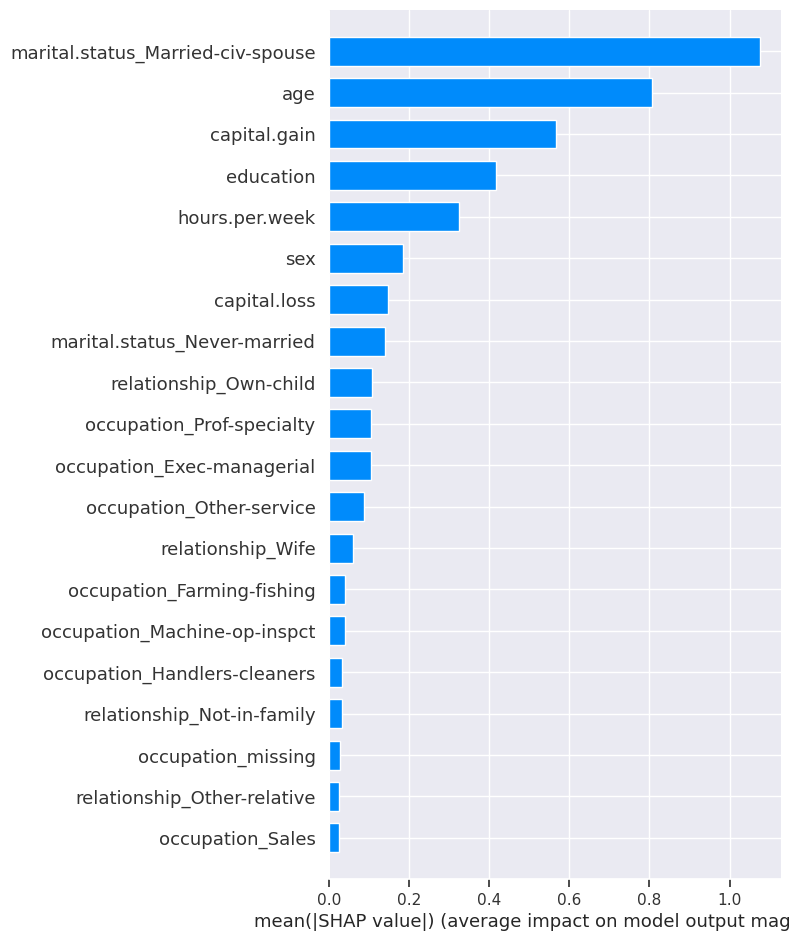

In [118]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

You can think of this as global feature importances.

<br><br><br><br>

In [119]:
# load JS visualization code to notebook
shap.initjs()

### Dependence plot

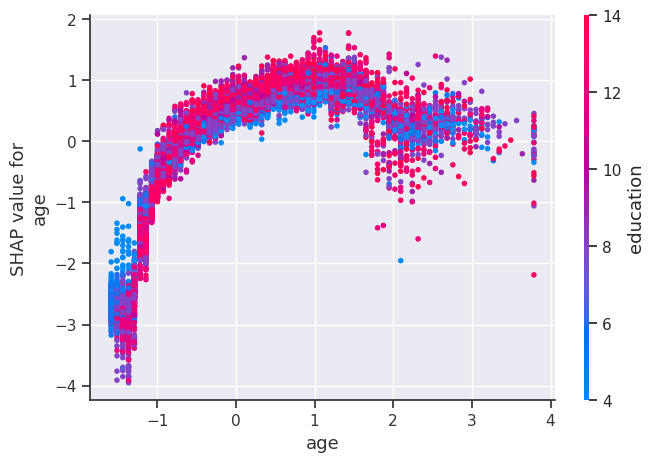

In [120]:
shap.dependence_plot("age", train_lgbm_shap_values[1], X_train_enc)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for examples above.
- The x-axis represents values of the feature age (scaled).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that example's prediction. 
- Lower values of age have smaller SHAP values for class ">50K".
- Similarly, higher values of age also have a bit smaller SHAP values for class ">50K", which makes sense.  
- There is some optimal value of age between scaled age of 1 which gives highest SHAP values for for class ">50K". 
- Ignore the colour for now. The color corresponds to a second feature (education feature in this case) that may have an interaction effect with the feature we are plotting. 

### Summary plot 

In [121]:
warnings.simplefilter(action="ignore", category=UserWarning)  # ignore warnings

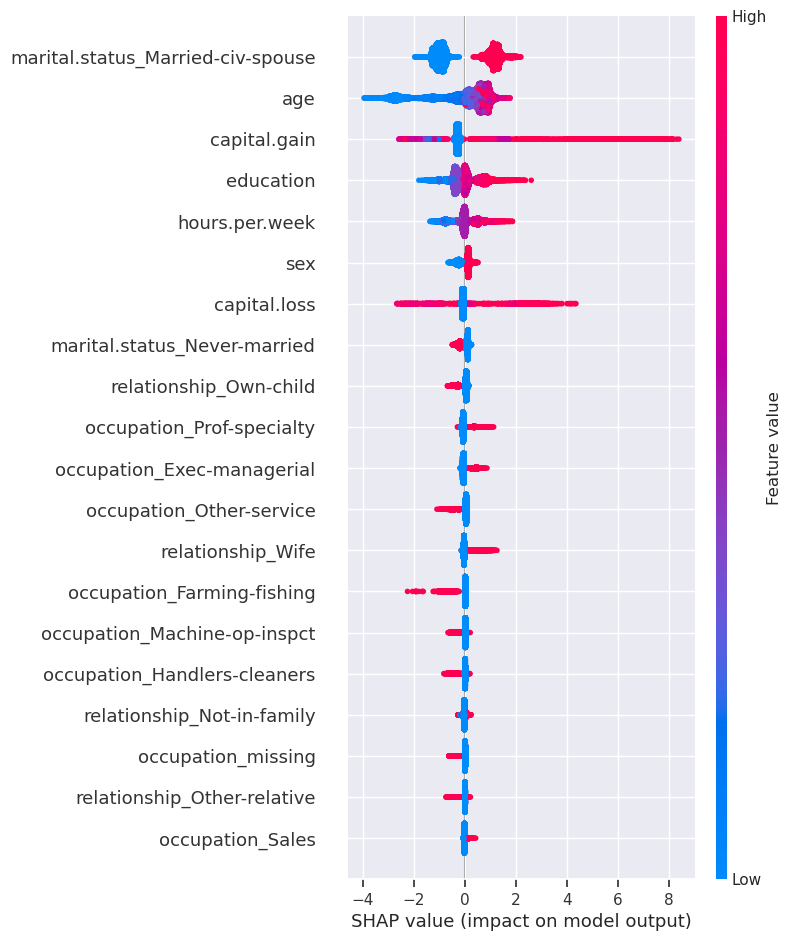

In [122]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

In [123]:
warnings.simplefilter(action="default", category=UserWarning)  # reactivate warnings

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- Presence of the marital status of Married-civ-spouse seems to have bigger SHAP values for class 1 and absence seems to have smaller SHAP values for class 1. 
- Higher levels of education seem to have bigger SHAP values for class 1 whereas smaller levels of education have smaller SHAP values. 

Provides explainer for different kinds of models

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)


- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. 

![](img/shap_image_explainer.png)
<!-- <img src="img/shap_image_explainer.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

<br><br>

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be used on **deployment** predictions!

<br><br>

## ❓❓ Questions for you

iClicker join links

- CPSC 330 **911**
  - https://join.iclicker.com/LFDB
- CPSC 330 **912**
  - https://join.iclicker.com/GJMY

### iClicker Exercise 12.1 

**Select all of the following statements which are TRUE.**

- (A) You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by `feature_importances_` attribute of your model means that increasing the value of feat1 will drive us towards positive class. 
- (B) eli5 can be used to get feature importances for non `sklearn` models. 
- (C) With SHAP you can only explain predictions on the training examples. 